# Lab 4: Classification with Logistic Regression and SVM
In this lab we will get some more practice with classification methods(Logistic Regression and Support Vector Machines), cross validation.

As in the previous lab we will be working with projects.csv and outcomes.csv from Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [3]:
# Load data
proj = pd.read_csv('data/projects.csv')
outcomes = pd.read_csv('data/outcomes.csv')

# 1) Cleaning the dataset

As you have probably noticed, this dataset has a mix of continuous features and categorical features(encoded as strings).
Before we can apply any of our classification algorithms to predict the is_exciting variable, we first need our desired features in the correct format.

In [4]:
print("Length of proj: %d" %len(proj))
print("Length of outcomes: %d" %len(proj))
print("Count of proj.project_id: %d" %proj.projectid.count())
print("Count of outcomes.project_id: %d" %outcomes.projectid.count())
print("Count of outcomes.is_exciting: %d" %outcomes.is_exciting.count())

Length of proj: 664098
Length of outcomes: 664098
Count of proj.project_id: 664098
Count of outcomes.project_id: 619326
Count of outcomes.is_exciting: 619326


In [5]:
# Join on project id
all_data = pd.merge(proj, outcomes, how='inner', left_on='projectid', right_on='projectid')
y_values = all_data['is_exciting'].astype(np.bool)
all_x_values = all_data[proj.columns]

# pick the features you want to use
features = []
x_values = all_x_values[features]

## Fix datatypes
You'll notice that a ton of the columns are binary or true/false columns. But all of them are encoded as 't'/'f' strings. If we want to feed these variables into any of the sklearn classifiers, we need to fix this. Convert all of the binary columns to booleans. Hint: use the astype, or apply functions.

In [6]:
def convert_bools(df, bool_cols):
    bool_cols = []
    for col in bool_cols:
        df[col] = df[col].astype(np.bool)
        # Alternatively
        # proj[col] = proj[col].apply(np.bool)

# apply it to the dataframe
bool_cols = []
convert_bools(x_values, bool_cols)

## Binarize categorical features
Most of the non-numerical/non-id columns are strings but they really exist as a discrete set of categories. For example: the "poverty_level" column takes on 4 values: "low poverty", "moderate poverty", "high poverty", and "highest poverty."  To convert these columns into a form that we can feed into our classifiers, we can need to convert this categorical variable to binary variables.

For each of the categorical features you want to add to the classifier, convert the column into a set of binary/indicator columns. The pandas function [get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) might be helpful for this.

In [7]:
def binarize_categories(df, cat_cols, drop=True):
    '''
    df: a pandas dataframe
    cat_cols: list of column names to generate indicator columns for
    drop: a bool. If true, drop the original category columns
    Returns: the modified dataframe
    '''
    for col in cat_cols:
        binary_cols = pd.get_dummies(df[col], col)
        df = pd.merge(df, binary_cols, left_index=True, right_index=True, how='inner')
    if drop:
        df.drop(cat_cols, inplace=True, axis=1)
    return df

In [8]:
# dummy test example before running it on the real dataframe
d = pd.DataFrame({'a': [5,6,7], 'b':[0,1,3]}, index=[10,13,14])
d = binarize_categories(d, ['a'], True)
d.head()

,b,a_5,a_6,a_7
10,0,1,0,0
13,1,0,1,0
14,3,0,0,1


In [9]:
# apply it to the real dataframe
cat_cols = []
cleaned_x_values = binarize_categories(x_values, cat_cols, drop=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Handle missing values

In [10]:
# Check the proportion of missing values from columns
for c in proj.columns:
    if proj[c].count() < len(proj):
        missing_perc = ((len(proj) - proj[c].count()) / float(len(proj))) * 100.0
        print("%.1f%% missing from: Column %s" %(missing_perc, c))

6.4% missing from: Column school_ncesid
0.0% missing from: Column school_zip
12.3% missing from: Column school_metro
0.1% missing from: Column school_district
0.0% missing from: Column school_county
0.0% missing from: Column teacher_prefix
0.0% missing from: Column primary_focus_subject
0.0% missing from: Column primary_focus_area
31.3% missing from: Column secondary_focus_subject
31.3% missing from: Column secondary_focus_area
0.0% missing from: Column resource_type
0.0% missing from: Column grade_level
5.3% missing from: Column fulfillment_labor_materials
0.0% missing from: Column students_reached


A decent chunk of the columns are missing values. If you're using features that are missing values, you need to do something to take care of them(IE: drop those rows, fill in the missing value, add a new category that corresponds to missing value, etc).

In [11]:
# drop rows
x_values = cleaned_x_values.dropna()

In [12]:
# we've done a ton of cleaning and it can be hard to keep track of all this stuff
# in the future, it would be good to just have a clean_data function that takes care of all this

## Split the data 
Split the data into a training set and a test set.

In [14]:
# 80/20 train test split. But you can tweak the test size
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.20, random_state=17)

# 2) Applying Logistic Regression

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

You'll notice that LogisticRegression takes a ton of parameters. We'll play around with the "penalty" and "C" parameters.
If we set the penalty parameter to ['l2'](http://mathworld.wolfram.com/L2-Norm.html), sklearn's LogisticRegression model solves the following minimization problem:

$$ \min_{\beta} ||\beta||_2 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

Similarly, if we set the penalty parameter to ['l1'](http://mathworld.wolfram.com/L2-Norm.html), LogisticRegression will solve the following minimization problem:

$$\min_{\beta} ||\beta||_1 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

where $$||\beta||_2 = \sqrt { \sum_{i} \beta_i^2 }$$ and $$||\beta||_1 =  \sum_{i} | \beta_i | $$ 

Try running logistic regression with both L1 and L2 penalties and a mix of C values with K-fold cross validation on the training set. If the K-fold cross validation takes too long, consider using a smaller subset of the data. Write a function to perform the cross validation over both penalties, and a range of C values. Hint: recall the "wonderful for loop" from lecture.

In [26]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_logistic_regression(x_values, y_values, c_vals, folds=5):
    # Keep track of both the accuracy scores and the model generated
    scores = {'l1': {}, 'l2': {}}
    models = {'l1': {}, 'l2': {}}
    kf = KFold(folds)
    
    for train_indices, test_indices in kf.split(df):
        x_train, x_test = x_values[train_indices], x_values[test_indices]
        y_train, y_test = y_values[train_indices], y_values[test_indices]
        for lpenalty in ['l1', 'l2']:
            for c in c_vals:
                lr = LogisticRegression(penalty=lpenalty, C=c)
                lr.fit(x_train, y_train)
                y_predict = lr.predict(x_test)
                scores[lpenalty][c] = accuracy_score(y_test, y_predict)
                print("%s with C = %.2f score: %.2f" %(lpenalty, c, scores[lpenalty][c]))
    return scores, models

What combination of parameters gives the highest cross validation score?

In [34]:
c_values = [10**i for i in range(-2, 3)]
scores, models = cv_logistic_regression(X_train, y_train, c_values)

AttributeError: 'KFold' object has no attribute 'split'

In [27]:
print(sklearn.__version__)

0.16.1


To really see the difference between L1 and L2 regularization, we need to take a closer look at the models they produced. Plot a histogram of the weight values of LogisticRegression models for each C value. You can access these weight coefficients via the coef\_ attribute in LogisticRegression. Do you notice anything interesting happening as the C value varies?

NameError: name 'models' is not defined

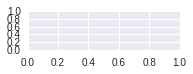

In [18]:
# Plot histogram of weights for l1 and l2 models
num_rows = len(c_values)
num_cols = 2
plt.subplot()
index = 1
for penalty in ('l1', 'l2'):
    for c in c_values:
        plt.subplot(num_rows, num_cols, index)
        plt.hist(models[penalty][c].coef_, bins=30)
        plt.title('Logistic Regression with %s penalty, C = %.2f' %(penalty, c))
        plt.xlabel('Weight values')
        plt.ylabel('Frequency')
        index += 1

You should see that the number of weight coefficients set to 0 in L1 regularized Logistic Regression increases with smaller C values. Revisit the minimization problems: you can think of the "C" parameter as a way of specifying the tradeoff between the L1/L2 penalty and the negative log likelihood of the model. A small value of "C" means that we are assigning greater weight to the L1/L2 penalty(equivalently downweighting the negative log likelihood).
L1 regularization induces sparse models - this can be a very useful if you suspect your classification target variable can be explained by few features.

Now try normalizing your continuous features. Rerun the logistic regression cross validation. Does normalization change the performance of Logistic Regression?

In [80]:
def normalize_cols(df, cols):
    for col in cols:
        df[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    return df

norm_cols = []
x_values = normalize_cols(x_values, norm_cols)
# rerun the cv_logistic_regression function

# remember that any data transformations you apply on the training set must be applied on the test set!

# 3) Applying SVM

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVC also takes quite a few parameters. We will be playing with following parameters:
* C
* kernel

SVM tries to find the hyperplane that maximizes the "margin" between the two classes of points. The "C" parameter in [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) has the same role as the "C" parameter in LogisticRegression: it tells you how much to penalize the "size" of the weight vector. Note that SVC only allows for L2 regularization.

## Choosing the kernel


As we did for LogisticRegression, write a function/some code to perform KFold crossvalidation on the training set to find the optimal C and kernel parameters. Repeat the cross validation after normalizing your continous features as well. Does normalization affect the SVM performance?

In [9]:
from sklearn.svm import SVC
def cv_svm(x_values, y_values, c_vals, kernels, folds):
    # Keep track of both the accuracy scores and the model generated
    scores = {k: {} for k in kernels}
    models = {k: {} for k in kernels}
    kf = KFold(folds)
    
    for train_indices, test_indices in kf.split(df):
        x_train, x_test = x_values[train_indices], x_values[test_indices]
        y_train, y_test = y_values[train_indices], y_values[test_indices]
        for k in kernels:
            for c in c_vals:
                svc = SVC(C=c, kernel=k)
                svc.fit(x_train, y_train)
                y_predict = lr.predict(x_test)
                scores[lpenalty][c] = accuracy_score(y_test, y_predict)
                print("%s kernel with C = %.2f score: %.2f" %(k, c, scores[k][c]))
    return scores, models

## 4) Class Imbalance and Evaluation Metrics

As noted in lecture, accuracy is not necessarily the best way to evaluate your classifier. This is especially true in situations where
our classification dataset has class imbalance. In our current dataset, we have the following class proportions:

In [107]:
exciting_prop = len(outcomes.is_exciting[outcomes.is_exciting == 't']) / float(len(outcomes.is_exciting))
print("Exciting proportion: %.2f" %exciting_prop)
print("Not exciting proportion: %.2f" % (1 - exciting_prop))

Exciting proportion: 0.06
Not exciting proportion: 0.94


Based on these proportions, a trivial classifier that simply outputs "Not exciting" no matter what the input features are will have
an accuracy of 94%. So try changing your cross validation functions above to optimize for precision, recall, F1 score, any any other [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) you've seen in lecture. Hint: make the classification scoring function a parameter to your cross validation function above.

In [ ]:
# Use grid search cv: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Both LogisticRegression and SVC have a class_weight parameter that allows you to specify how much the model should prefer correctly classifying one class over another. Try specifying this parameter in your models and see how this affects the evaluation metrics you just tried above. 

## Additional Steps
If you have the time, here are some additional things to try:
* pull in other features from the other csv files from the Kaggle
* try adding transformed features into the models(IE: squared values, products of features, etc)
* you've written a cv_logistic_regression function and a cv_svm function which probably look very similar. Try writing a cross validation function that takes a model(IE: LogisiticRegression, SVC, DecisionTreeClassifier) as a parameter as well so that we can just do cv_model(SVC, ....) and cv_model(LogisticRegression, ...)